In [43]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scripts.data_clean_utils import full_data_cleaning_pipeline
from scipy.stats import chi2_contingency, f_oneway, jarque_bera, probplot
import plotly.express as px
import nbformat
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PowerTransformer

In [3]:
from sklearn import set_config
set_config(display='pandas')

In [4]:
BASE_DIR = Path().resolve().parent

DATA_PATH_DIR =  BASE_DIR / 'data' / 'raw' / 'Food Delivery Time Prediction Case Study.xlsx'

df = pd.read_excel(DATA_PATH_DIR, sheet_name="Sheet1")

In [5]:
df = full_data_cleaning_pipeline(df)

In [6]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'type_of_order', 'type_of_vehicle', 'time_taken', 'city_name',
       'distance', 'distance_type'],
      dtype='object')

In [7]:
columns_to_drop = ['rider_id', 
                   'restaurant_latitude', 
                   'restaurant_longitude', 
                   'delivery_latitude', 
                   'delivery_longitude', 
                   ]

df.drop(columns=columns_to_drop, inplace=True)
df.columns

Index(['age', 'ratings', 'type_of_order', 'type_of_vehicle', 'time_taken',
       'city_name', 'distance', 'distance_type'],
      dtype='object')

In [8]:

df

,age,ratings,type_of_order,type_of_vehicle,time_taken,city_name,distance,distance_type
0,37,4.9,Snack,motorcycle,24,INDO,3.025149,short
1,34,4.5,Snack,scooter,33,BANG,20.183530,very long
2,23,4.4,Drinks,motorcycle,26,BANG,1.552758,short
3,38,4.7,Buffet,motorcycle,21,COIMB,7.790401,medium
4,32,4.6,Snack,scooter,30,CHEN,6.210138,medium
...,...,...,...,...,...,...,...,...
45588,30,4.8,Meal,motorcycle,32,JAP,1.489846,short
45589,21,4.6,Buffet,motorcycle,36,AGR,NaN,NaN
45590,30,4.9,Drinks,scooter,16,CHEN,4.657195,short
45591,20,4.7,Snack,motorcycle,26,COIMB,6.232393,medium


In [9]:
df.isna().sum()

age                   0
ratings               0
type_of_order         0
type_of_vehicle       0
time_taken            0
city_name             0
distance           3630
distance_type      3630
dtype: int64

<Axes: >

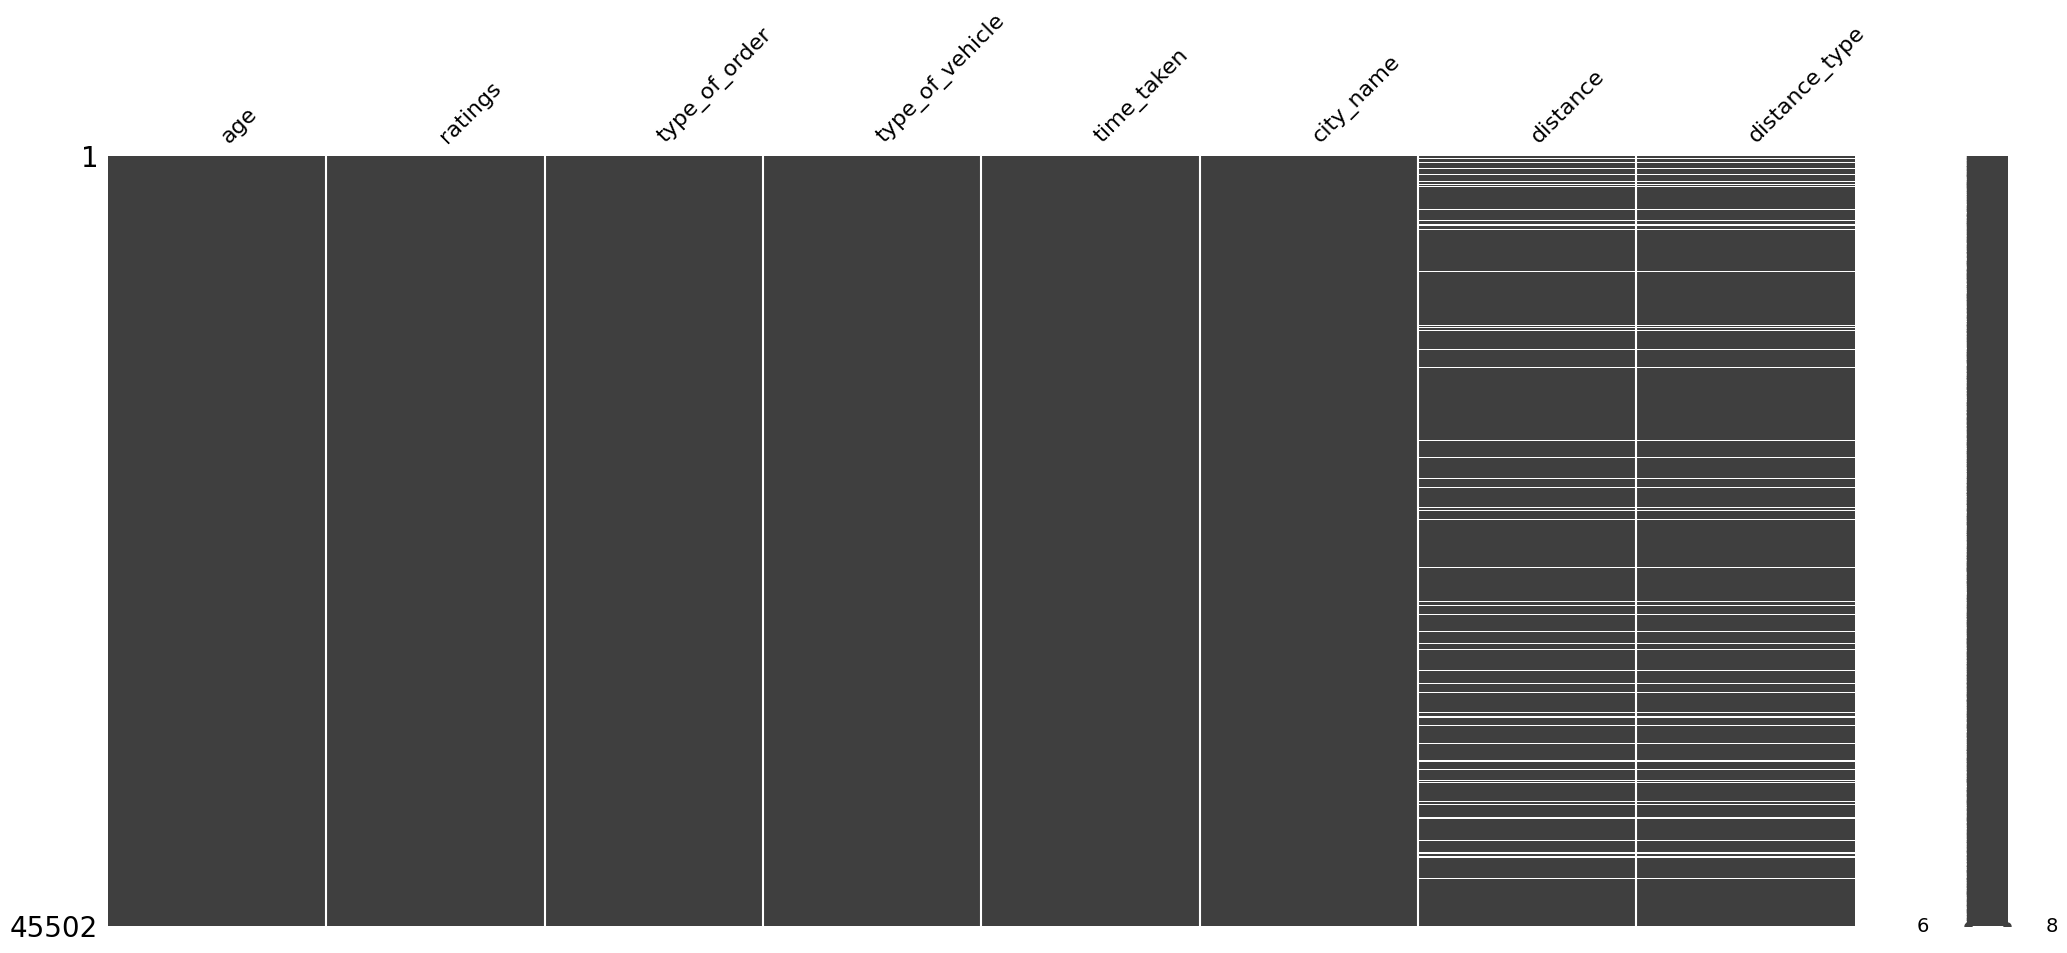

In [10]:
import missingno as msno
msno.matrix(df)

In [11]:
temp_df = df.copy()
temp_df.dropna(inplace=True)

In [12]:
x = temp_df.drop(columns=["time_taken"])
y = temp_df["time_taken"]

In [13]:
x_teain , x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
x_teain.shape

(33497, 7)

In [15]:
x_teain.isna().sum()

age                0
ratings            0
type_of_order      0
type_of_vehicle    0
city_name          0
distance           0
distance_type      0
dtype: int64

In [16]:
num_col = x_teain.select_dtypes(include=['int64', 'float64']).columns
nominal_col = [
    
    'type_of_order', 
    'type_of_vehicle', 
    'city_name'
]

original_col = ["distance_type"]

In [17]:
for col in original_col:
    print(col, x_teain[col].unique())

distance_type ['medium', 'long', 'very long', 'short']
Categories (4, object): ['short' < 'medium' < 'long' < 'very long']


In [18]:
distance_type_order = ['medium', 'long', 'very long', 'short']

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder

preprocessing = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_col),

        ('ord', OrdinalEncoder(
            categories=[distance_type_order],
            handle_unknown="use_encoded_value",
            unknown_value=-1
        ), original_col),

        ('nom', OneHotEncoder(
            drop='first',
            handle_unknown='ignore',
            sparse_output=False
        ), nominal_col)
    ],
    remainder="passthrough",
    n_jobs=-1,
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
)



In [20]:
preprocessing.set_output(transform="pandas")

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 Index(['age', 'ratings', 'distance'], dtype='object')),
                                ('ord',
                                 OrdinalEncoder(categories=[['medium', 'long',
                                                             'very long',
                                                             'short']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['distance_type']),
                                ('nom',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['type_

In [21]:
x_teain_preprocessed = preprocessing.fit_transform(x_teain)
x_test_preprocessed = preprocessing.transform(x_test)

d:\FInal project\Project 2\Food Delivery Time Prediction API\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


In [22]:
x_teain_preprocessed.shape, x_test_preprocessed.shape

((33497, 31), (8375, 31))

In [23]:
x_teain_preprocessed

,age,ratings,distance,distance_type,type_of_order_Drinks,type_of_order_Meal,type_of_order_Snack,type_of_vehicle_electric_scooter,type_of_vehicle_motorcycle,type_of_vehicle_scooter,...,city_name_KNP,city_name_KOC,city_name_KOL,city_name_LUDH,city_name_MUM,city_name_MYS,city_name_PUNE,city_name_RANCHI,city_name_SUR,city_name_VAD
5798,0.947368,0.96,0.243692,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27545,0.315789,0.72,0.472645,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30047,0.315789,0.84,0.930760,2.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7337,0.842105,0.68,0.313168,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13993,0.631579,0.68,0.563918,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6832,0.947368,0.96,0.777795,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12305,0.526316,1.00,0.080035,3.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41540,1.000000,0.60,0.543894,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
943,0.736842,0.84,0.314608,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
pt = PowerTransformer()

y_train_preprocessed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_preprocessed = pt.transform(y_test.values.reshape(-1, 1)) 

In [25]:
y_train_preprocessed

array([[ 2.03656336],
       [ 0.58904841],
       [ 0.39565491],
       ...,
       [ 1.3683564 ],
       [-0.73548834],
       [-0.36138347]], shape=(33497, 1))

Train Baslene modle

In [26]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_model.fit(x_teain_preprocessed, y_train_preprocessed)

LinearRegression()

In [27]:
y_pred_train = lr_model.predict(x_teain_preprocessed)
y_pred_test = lr_model.predict(x_test_preprocessed)

In [28]:
y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

In [29]:

print("Train MAE:", mean_absolute_error(y_train, y_pred_train_org))
print("Train r2:", r2_score(y_train, y_pred_train_org))

Train MAE: 6.2570986201343075
Train r2: 0.28837157082266507


In [30]:
print("test mae:", mean_absolute_error(y_test, y_pred_test_org) )
print("test r2:", r2_score(y_test, y_pred_test_org) )

test mae: 6.179601291461564
test r2: 0.2942592320788433


# impute missing valuse

In [31]:
temp_df_impute = df.copy()

In [32]:
X = temp_df_impute.drop(columns=["time_taken"])
y = temp_df_impute["time_taken"]

In [33]:
print(X.shape, y.shape)

(45502, 7) (45502,)


In [34]:
X

,age,ratings,type_of_order,type_of_vehicle,city_name,distance,distance_type
0,37,4.9,Snack,motorcycle,INDO,3.025149,short
1,34,4.5,Snack,scooter,BANG,20.183530,very long
2,23,4.4,Drinks,motorcycle,BANG,1.552758,short
3,38,4.7,Buffet,motorcycle,COIMB,7.790401,medium
4,32,4.6,Snack,scooter,CHEN,6.210138,medium
...,...,...,...,...,...,...,...
45588,30,4.8,Meal,motorcycle,JAP,1.489846,short
45589,21,4.6,Buffet,motorcycle,AGR,NaN,NaN
45590,30,4.9,Drinks,scooter,CHEN,4.657195,short
45591,20,4.7,Snack,motorcycle,COIMB,6.232393,medium


In [35]:
x_teain , x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
x_teain.head()

,age,ratings,type_of_order,type_of_vehicle,city_name,distance,distance_type
11047,26,4.7,Snack,electric_scooter,MUM,9.177684,medium
15692,21,4.9,Drinks,motorcycle,SUR,6.081536,medium
14499,29,4.6,Meal,scooter,MYS,1.554563,short
29258,32,4.7,Buffet,motorcycle,JAP,20.852271,very long
22554,34,4.9,Meal,scooter,RANCHI,9.056096,medium


In [36]:
x_teain.isna().sum()

age                   0
ratings               0
type_of_order         0
type_of_vehicle       0
city_name             0
distance           2931
distance_type      2931
dtype: int64

In [37]:
pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_pt = pt.transform(y_test.values.reshape(-1, 1))

In [39]:
(
    x_teain
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)

np.float64(8.0)

Impute Distance           

In [41]:
x_teain["distance"].describe()

count    33470.000000
mean         9.738154
std          5.608401
min          1.465067
25%          4.657672
50%          9.193421
75%         13.681057
max         20.969489
Name: distance, dtype: float64

In [44]:
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')  

In [45]:
num_col = x_teain.select_dtypes(include=['int64', 'float64']).columns
nominal_col = [
    
    'type_of_order', 
    'type_of_vehicle', 
    'city_name'
]

original_col = ["distance_type"]

In [46]:
distance_type_order = [
   'short', 'medium', 'long', 'very long'
]

In [47]:
for col in original_col:
    print(col, x_teain[col].unique())

distance_type ['medium', 'short', 'very long', 'long', NaN]
Categories (4, object): ['short' < 'medium' < 'long' < 'very long']


In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

preprocessing = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_col),

        ('ord', OrdinalEncoder(
            categories=[distance_type_order],
            encoded_missing_value=-999,
            handle_unknown="use_encoded_value",
            unknown_value=-1
        ), original_col),

        ('nom', OneHotEncoder(
            drop='first',
            handle_unknown='ignore',
            sparse_output=False
        ), nominal_col)
    ],
    remainder="passthrough",
    n_jobs=-1,
    verbose_feature_names_out=False
)


In [61]:
preprocessing

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 Index(['age', 'ratings', 'distance'], dtype='object')),
                                ('ord',
                                 OrdinalEncoder(categories=[['short', 'medium',
                                                             'long',
                                                             'very long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['distance_type']),
                                ('nom',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
              

In [ ]:
preprocessing.set_output(transform="pandas")


ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 Index(['age', 'ratings', 'distance'], dtype='object')),
                                ('ord',
                                 OrdinalEncoder(categories=[['short', 'medium',
                                                             'long',
                                                             'very long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['distance_type']),
                                ('nom',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
              

In [69]:
preprocessing.fit_transform(x_teain)["distance_type"].value_counts()

distance_type
 2.0    9025
 0.0    8998
 1.0    8993
 3.0    6454
-1.0    2931
Name: count, dtype: int64

In [62]:
x_teain["distance_type"].value_counts()

distance_type
long         9025
short        8998
medium       8993
very long    6454
Name: count, dtype: int64

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 Index(['age', 'ratings', 'distance'], dtype='object')),
                                ('ord',
                                 OrdinalEncoder(categories=[['short', 'medium',
                                                             'long',
                                                             'very long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['distance_type']),
                                ('nom',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
              

In [70]:
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputer', knn_imputer)
])
preprocessing_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['age', 'ratings', 'distance'], dtype='object')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very '
                                                                              'long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                              

In [72]:
preprocessing_pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['age', 'ratings', 'distance'], dtype='object')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very '
                                                                              'long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                              

In [74]:
preprocessing_pipeline.fit_transform(x_teain).isna().sum()

age                                  0
ratings                              0
distance                             0
distance_type                        0
type_of_order_Drinks                 0
type_of_order_Meal                   0
type_of_order_Snack                  0
type_of_vehicle_electric_scooter     0
type_of_vehicle_motorcycle           0
type_of_vehicle_scooter              0
city_name_ALH                        0
city_name_AURG                       0
city_name_BANG                       0
city_name_BHP                        0
city_name_CHEN                       0
city_name_COIMB                      0
city_name_DEH                        0
city_name_GOA                        0
city_name_HYD                        0
city_name_INDO                       0
city_name_JAP                        0
city_name_KNP                        0
city_name_KOC                        0
city_name_KOL                        0
city_name_LUDH                       0
city_name_MUM            

In [75]:
lr = LinearRegression()

model_pipe = Pipeline(steps=[
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('linear_regression', lr)
])

model_pipe

Pipeline(steps=[('preprocessing_pipeline',
                 Pipeline(steps=[('preprocessing',
                                  ColumnTransformer(n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('num',
                                                                   MinMaxScaler(),
                                                                   Index(['age', 'ratings', 'distance'], dtype='object')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very

In [82]:
model_pipe.fit(x_teain, y_train_pt)

Pipeline(steps=[('preprocessing_pipeline',
                 Pipeline(steps=[('preprocessing',
                                  ColumnTransformer(n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('num',
                                                                   MinMaxScaler(),
                                                                   Index(['age', 'ratings', 'distance'], dtype='object')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very

In [ ]:
y_pred_train = model_pipe.predict(x_teain)
y_pred_test = model_pipe.predict(x_test)

In [83]:
y_pred_train_ong = pt.inverse_transform(y_train_pt.reshape(-1, 1))
y_pred_test_ong = pt.inverse_transform(y_train_pt.reshape(-1, 1))

In [84]:
print("Train MAE:", mean_absolute_error(y_train, y_pred_train_ong))
print("Train r2:", r2_score(y_train, y_pred_train_ong))

Train MAE: 5.404319611532121e-15
Train r2: 1.0


In [86]:
print("Train MAE:", mean_absolute_error(y_train, y_pred_test_ong))
print("Train r2:", r2_score(y_train, y_pred_test_ong))

Train MAE: 5.404319611532121e-15
Train r2: 1.0
